In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications.efficientnet import preprocess_input as enpi
from tensorflow.keras.applications.densenet import preprocess_input as dnpi
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


2024-08-17 14:01:27.441344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 14:01:27.441489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 14:01:27.578879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
path = '/kaggle/input/dataset/dataset3'
classes = os.listdir(path)
classes

['unknown', 'Viral _Pneumonia', 'Normal', 'Bacterial_Pnemonia']

In [3]:
paths = list(glob.glob(path+'/**/*.*'))

In [4]:
paths[1:10]

['/kaggle/input/dataset/dataset3/unknown/22706.jpg',
 '/kaggle/input/dataset/dataset3/unknown/22608.jpg',
 '/kaggle/input/dataset/dataset3/unknown/23407.jpg',
 '/kaggle/input/dataset/dataset3/unknown/23149.jpg',
 '/kaggle/input/dataset/dataset3/unknown/21494.jpg',
 '/kaggle/input/dataset/dataset3/unknown/20777.jpg',
 '/kaggle/input/dataset/dataset3/unknown/23274.jpg',
 '/kaggle/input/dataset/dataset3/unknown/22046.jpg',
 '/kaggle/input/dataset/dataset3/unknown/20938.jpg']

In [5]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], paths))
labels[1:10]

['unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown',
 'unknown']

In [6]:

filepath = pd.Series(paths, name='Path').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Path,Label
0,/kaggle/input/dataset/dataset3/Bacterial_Pnemo...,Bacterial_Pnemonia
1,/kaggle/input/dataset/dataset3/Bacterial_Pnemo...,Bacterial_Pnemonia
2,/kaggle/input/dataset/dataset3/Bacterial_Pnemo...,Bacterial_Pnemonia
3,/kaggle/input/dataset/dataset3/Normal/Normal_1...,Normal
4,/kaggle/input/dataset/dataset3/Viral _Pneumoni...,Viral _Pneumonia


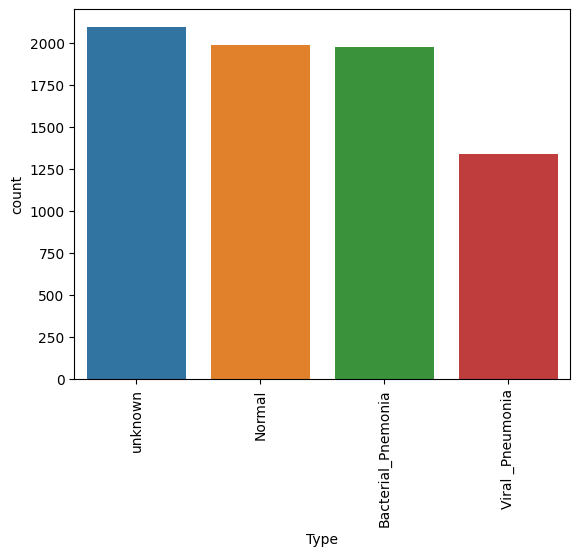

In [7]:
imagecount = data.Label.value_counts()
sns.barplot(x=imagecount.index, y=imagecount)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [8]:
traindata, testdata = train_test_split(data, test_size=0.30, random_state=42)
valdata, testdata = train_test_split(testdata, test_size=0.50, random_state=42)

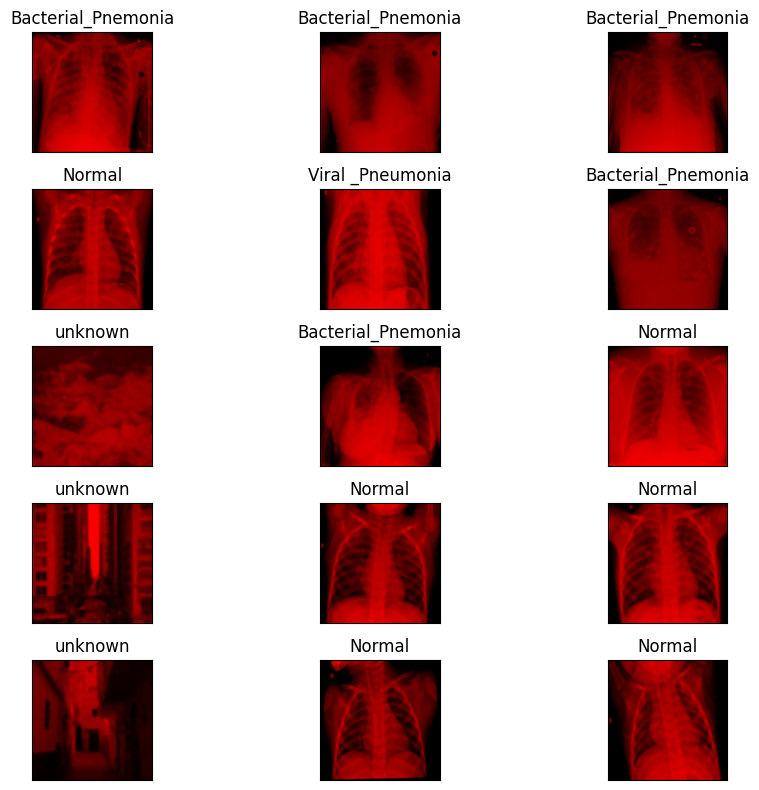

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Path[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [10]:
train_datagen_enpi = ImageDataGenerator(preprocessing_function=enpi,validation_split=0.2)
test_datagen_enpi = ImageDataGenerator(preprocessing_function=enpi)

In [11]:
train_gen_en = train_datagen_enpi.flow_from_dataframe(
    dataframe=traindata,
    x_col='Path',
    y_col='Label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
)
val_gen_en = train_datagen_enpi.flow_from_dataframe(
    dataframe=valdata,
    x_col='Path',
    y_col='Label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42
)
test_gen_en = test_datagen_enpi.flow_from_dataframe(
    dataframe=testdata,
    x_col='Path',
    y_col='Label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 5186 validated image filenames belonging to 4 classes.
Found 1111 validated image filenames belonging to 4 classes.
Found 1112 validated image filenames belonging to 4 classes.


In [12]:
basemodel_efficientnet = EfficientNetB0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='/kaggle/input/efficientnetnotop/efficientnetb0_notop.h5',
    pooling='avg'
)

basemodel_efficientnet.trainable = True
for layer in basemodel_efficientnet.layers[:-20]:
    layer.trainable=False



x = Dense(128, activation='relu')(basemodel_efficientnet.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(4, activation='softmax')(x)

finalmodel = Model(inputs=basemodel_efficientnet.input, outputs=outputs)


In [13]:
finalmodel.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
callback = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [15]:
history_en = finalmodel.fit(
    train_gen_en,
    validation_data=val_gen_en,
    epochs=20,
    callbacks=callback
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/82 ━━━━━━━━━━━━━━━━━━━━ 1:04:18 48s/step - accuracy: 0.1406 - loss: 1.6734

I0000 00:00:1723903361.761497     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 112s 799ms/step - accuracy: 0.4240 - loss: 1.2441 - val_accuracy: 0.8452 - val_loss: 0.7000
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 195ms/step - accuracy: 0.7761 - loss: 0.6376 - val_accuracy: 0.8776 - val_loss: 0.4010
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.8303 - loss: 0.4938 - val_accuracy: 0.9001 - val_loss: 0.3034
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.8528 - loss: 0.4106 - val_accuracy: 0.9100 - val_loss: 0.2598
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.8668 - loss: 0.3582 - val_accuracy: 0.9118 - val_loss: 0.2418
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - accuracy: 0.8876 - loss: 0.3275 - val_accuracy: 0.9145 - val_loss: 0.2340
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step - accuracy: 0.8831 - loss: 0.3202 - val_accuracy: 0.9172 - val_loss: 0.2207
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 197ms/step - accuracy: 0.8977 - loss: 0.2779 - val_accuracy: 0.91

In [16]:
finalmodel.save("model_efficientnet.h5")  

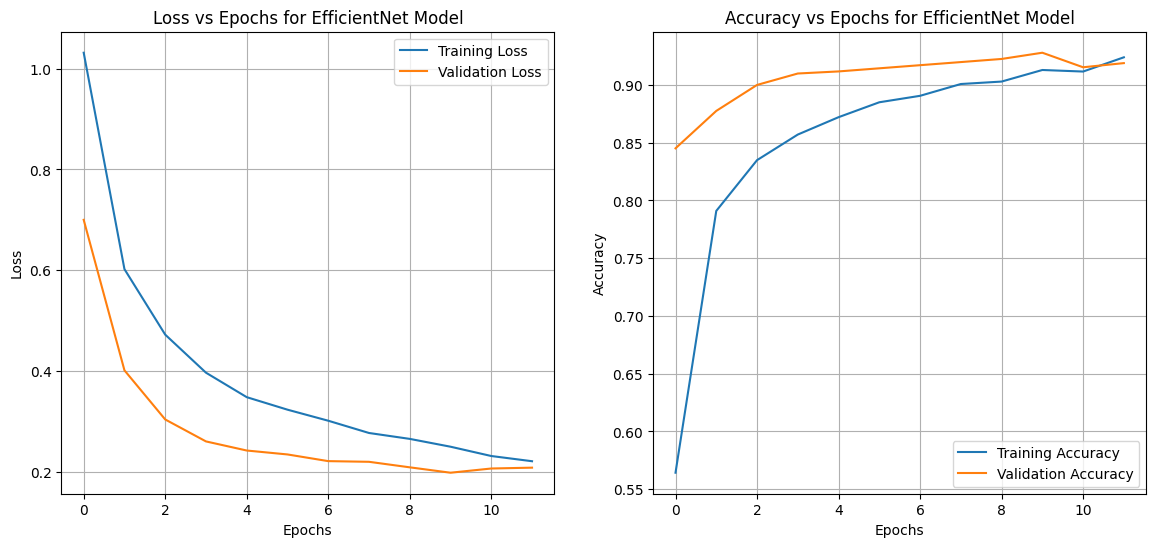

In [17]:
plt.figure(figsize=(14, 6))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history_en.history['loss'], label='Training Loss')
plt.plot(history_en.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs for EfficientNet Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history_en.history['accuracy'], label='Training Accuracy')
plt.plot(history_en.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs for EfficientNet Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [18]:
results_en = finalmodel.evaluate(test_gen_en, verbose=0)

print("    Test Loss: {:.5f}".format(results_en[0]))
print("Test Accuracy: {:.2f}%".format(results_en[1] * 100))

    Test Loss: 0.22478
Test Accuracy: 91.28%


In [19]:
predictions_en = finalmodel.predict(test_gen_en)
predicted_classes_en = np.argmax(predictions_en, axis=1)
label_map_en = {v: k for k, v in train_gen_en.class_indices.items()}
predicted_labels_en = [label_map_en[index] for index in predicted_classes_en]
true_labels_en = testdata['Label'].tolist()
print(classification_report(true_labels_en, predicted_labels_en))


18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 473ms/step
                    precision    recall  f1-score   support

Bacterial_Pnemonia       0.87      0.90      0.89       294
            Normal       0.84      0.88      0.86       296
  Viral _Pneumonia       0.95      0.87      0.91       216
           unknown       1.00      1.00      1.00       306

          accuracy                           0.91      1112
         macro avg       0.92      0.91      0.91      1112
      weighted avg       0.91      0.91      0.91      1112



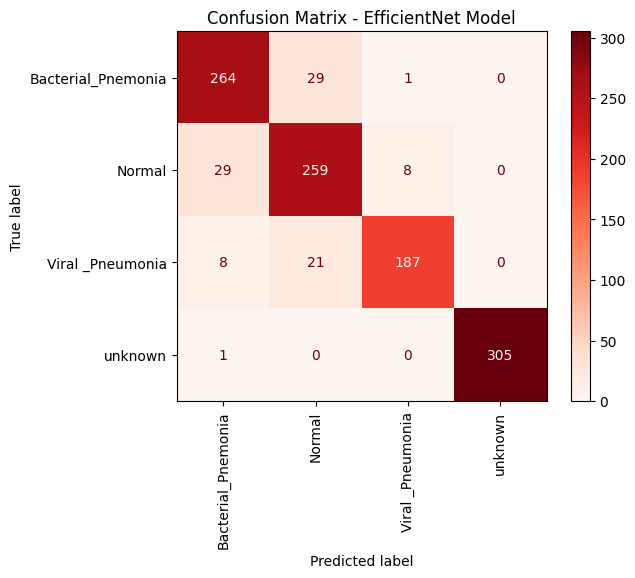

In [20]:
cm = confusion_matrix(true_labels_en, predicted_labels_en)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map_en.values()))
disp.plot(cmap='Reds')
plt.title('Confusion Matrix - EfficientNet Model')
plt.xticks(rotation=90)
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


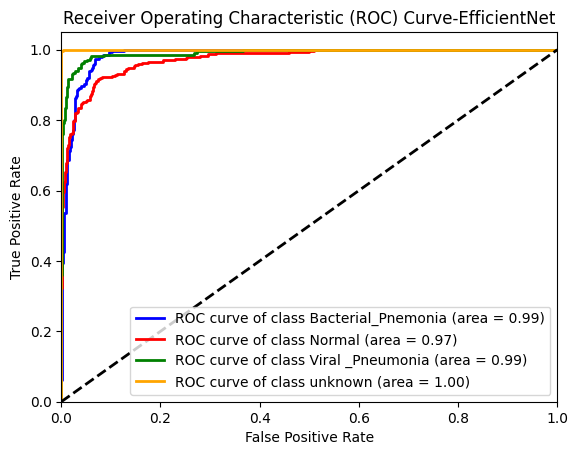

In [21]:
y_test_bin = label_binarize(true_labels_en, classes=list(label_map_en.values())) 
n_classes = y_test_bin.shape[1]


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], finalmodel.predict(test_gen_en)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])  
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(list(label_map_en.values())[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve-EfficientNet')
plt.legend(loc="lower right")
plt.show()


In [22]:
train_datagen_dn = ImageDataGenerator(preprocessing_function=dnpi,validation_split=0.2)
test_datagen_dn = ImageDataGenerator(preprocessing_function=dnpi)

In [23]:
train_gen_dn = train_datagen_dn.flow_from_dataframe(
    dataframe=traindata,
    x_col='Path',
    y_col='Label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42
)
valid_gen_dn = train_datagen_dn.flow_from_dataframe(
    dataframe=valdata,
    x_col='Path',
    y_col='Label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    shuffle=False,
    seed=42
)
test_gen_dn = test_datagen_dn.flow_from_dataframe(
    dataframe=testdata,
    x_col='Path',
    y_col='Label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 5186 validated image filenames belonging to 4 classes.
Found 1111 validated image filenames belonging to 4 classes.
Found 1112 validated image filenames belonging to 4 classes.


In [24]:
basemodel_dn = DenseNet121(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

basemodel_dn.trainable = True  


for layer in basemodel_dn.layers[:-30]:  
    layer.trainable = False
    
inputs = basemodel_dn.input


x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(basemodel_dn.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(4, activation='softmax')(x)

model_dn = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(learning_rate=0.0001)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model_dn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
callback_dn = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [27]:
history_dn = model_dn.fit(
    train_gen_dn,
    validation_data=valid_gen_dn,
    epochs=20,
    callbacks=callback_dn
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 99s 712ms/step - accuracy: 0.4349 - loss: 2.3268 - val_accuracy: 0.8272 - val_loss: 0.9772
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 78s 207ms/step - accuracy: 0.7935 - loss: 1.1042 - val_accuracy: 0.8893 - val_loss: 0.7774
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 209ms/step - accuracy: 0.8488 - loss: 0.9044 - val_accuracy: 0.9037 - val_loss: 0.7110
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.8729 - loss: 0.8238 - val_accuracy: 0.9127 - val_loss: 0.6666
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.8813 - loss: 0.7799 - val_accuracy: 0.9208 - val_loss: 0.6328
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - accuracy: 0.8973 - loss: 0.7113 - val_accuracy: 0.9289 - val_loss: 0.6021
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.9112 - loss: 0.6674 - val_accuracy: 0.9298 - val_loss: 0.5901
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.9142 - loss: 0.6563 - val_accuracy: 0.930

In [28]:
model_dn.save("model_densenet.h5")  

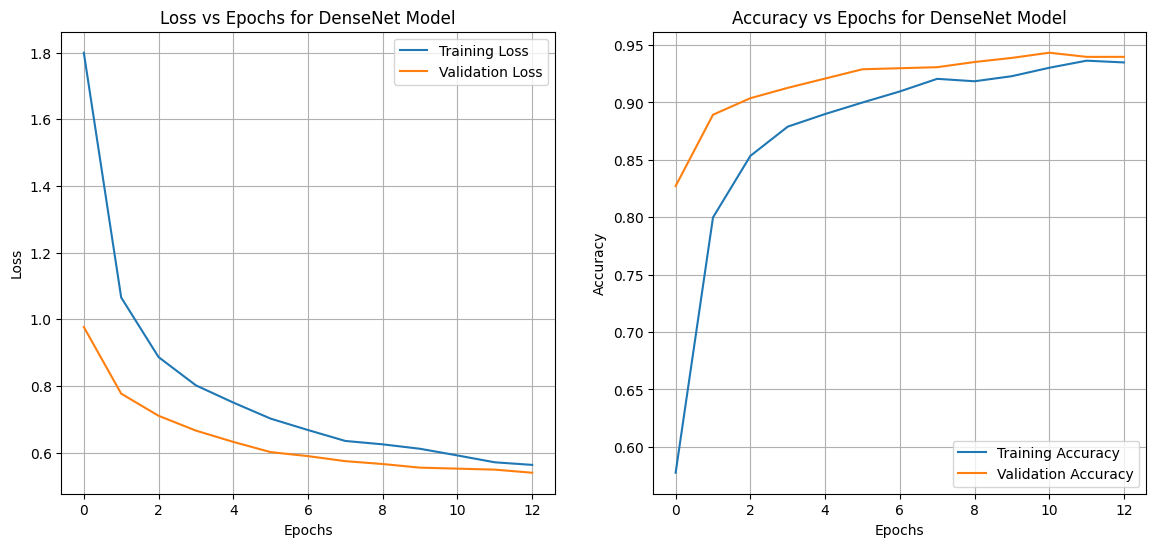

In [29]:
plt.figure(figsize=(14, 6))

# Plot Loss Curves
plt.subplot(1, 2, 1)
plt.plot(history_dn.history['loss'], label='Training Loss')
plt.plot(history_dn.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs for DenseNet Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(history_dn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs for DenseNet Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()


In [30]:
results_dn = model_dn.evaluate(test_gen_dn, verbose=0)

print("    Test Loss: {:.5f}".format(results_dn[0]))
print("Test Accuracy: {:.2f}%".format(results_dn[1] * 100))

    Test Loss: 0.57628
Test Accuracy: 92.81%


In [31]:
pred_dn = model_dn.predict(test_gen_dn)
pred_dn = np.argmax(pred_dn,axis=1)
labels = (test_gen_dn.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_dn = [labels[k] for k in pred_dn]

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 740ms/step


In [32]:
y_test_dn = list(testdata.Label)
print(classification_report(y_test_dn, pred_dn))

                    precision    recall  f1-score   support

Bacterial_Pnemonia       0.91      0.90      0.91       294
            Normal       0.86      0.89      0.87       296
  Viral _Pneumonia       0.95      0.91      0.93       216
           unknown       1.00      1.00      1.00       306

          accuracy                           0.93      1112
         macro avg       0.93      0.93      0.93      1112
      weighted avg       0.93      0.93      0.93      1112



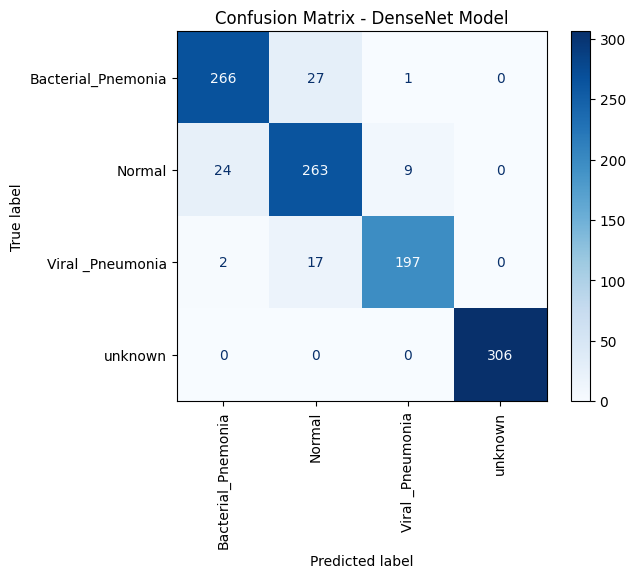

In [33]:
cm_dn = confusion_matrix(y_test_dn, pred_dn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dn, display_labels=list(labels.values()))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - DenseNet Model')
plt.xticks(rotation=90)
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step


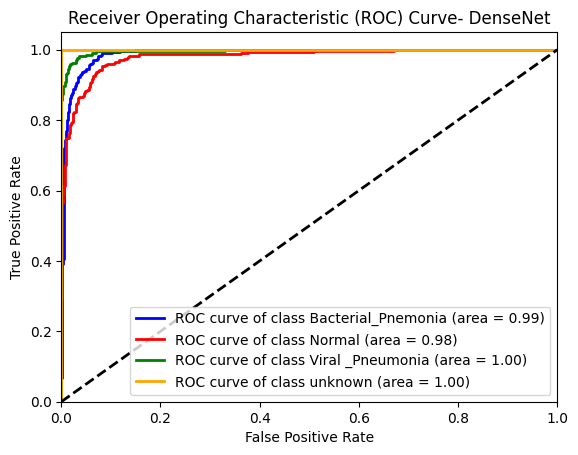

In [34]:
y_test_bin_dn = label_binarize(y_test_dn, classes=list(labels.values())) 
n_classes_dn = y_test_bin_dn.shape[1]

fpr_dn = dict()
tpr_dn = dict()
roc_auc_dn = dict()
for i in range(n_classes_dn):
    fpr_dn[i], tpr_dn[i], _ = roc_curve(y_test_bin_dn[:, i], model_dn.predict(test_gen_dn)[:, i])
    roc_auc_dn[i] = auc(fpr_dn[i], tpr_dn[i])

plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])  
for i, color in zip(range(n_classes_dn), colors):
    plt.plot(fpr_dn[i], tpr_dn[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc_dn[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- DenseNet')
plt.legend(loc="lower right")
plt.show()

In [35]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

# Load the pre-trained models
model_efficientnet = load_model('/kaggle/working/model_efficientnet.h5')
model_densenet = load_model('/kaggle/working/model_densenet.h5')

# Generate predictions for the test set
test_pred_efficientnet = model_efficientnet.predict(test_gen_en)
test_pred_densenet = model_densenet.predict(test_gen_dn)

# Assign weights to the models (you can adjust these based on validation performance)
weight_efficientnet = 0.3
weight_densenet = 0.7

# Weighted average of predictions
ensemble_pred = (weight_efficientnet * test_pred_efficientnet) + (weight_densenet * test_pred_densenet)

# Convert probabilities to class predictions
ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

# True labels
true_classes = test_gen_dn.classes

# Evaluate the ensemble performance
accuracy = accuracy_score(true_classes, ensemble_pred_classes)
report = classification_report(true_classes, ensemble_pred_classes, target_names=test_gen_en.class_indices.keys())

print(f'Ensemble Model Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:\n', report)


18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 681ms/step
Ensemble Model Accuracy: 93.62%
Classification Report:
                     precision    recall  f1-score   support

Bacterial_Pnemonia       0.91      0.91      0.91       294
            Normal       0.87      0.91      0.89       296
  Viral _Pneumonia       0.97      0.91      0.94       216
           unknown       1.00      1.00      1.00       306

          accuracy                           0.94      1112
         macro avg       0.94      0.93      0.94      1112
      weighted avg       0.94      0.94      0.94      1112



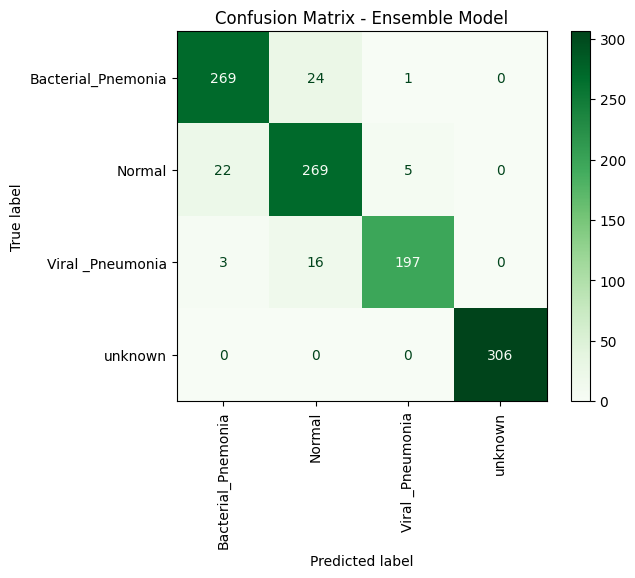

In [36]:
cm_ens= confusion_matrix(true_classes, ensemble_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ens, display_labels=list(test_gen_dn.class_indices.keys()))

disp.plot(cmap='Greens')
plt.title('Confusion Matrix - Ensemble Model')
plt.xticks(rotation=90)
plt.show()


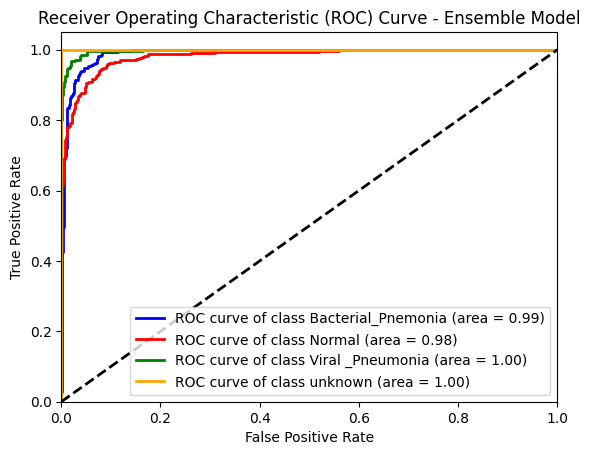

In [37]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for ROC curve
true_classes_b = label_binarize(true_classes, classes=list(test_gen_dn.class_indices.values()))
n_classe = true_classes_b.shape[1]


fp = dict()
tp = dict()
rocauc = dict()

for i in range(n_classe):
    fp[i], tp[i], _ = roc_curve(true_classes_b[:, i], ensemble_pred[:, i])
    rocauc[i] = auc(fp[i], tp[i])


plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])  
for i, color in zip(range(n_classe), colors):
    plt.plot(fp[i], tp[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(list(test_gen_dn.class_indices.keys())[i], rocauc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Ensemble Model')
plt.legend(loc="lower right")
plt.show()
